### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [2]:
#  merging the files
joined_files_s1 = os.path.join("Datasets_Healthy_Older_People", "S1_Dataset", "d1p*") 
joined_files_s2 = os.path.join("Datasets_Healthy_Older_People", "S2_Dataset", "d2p*")

# A list of all joined files is returned
joined_list_s1 = glob.glob(joined_files_s1)
joined_list_s2 = glob.glob(joined_files_s2)

# Addition of both list
joined_list_s1_s2 = joined_list_s1 + joined_list_s2

#Each csv file is read & converted into a pandas dataframe, concatenated all of the dataframes together and stack them one on top of each other
cols_names = ['Time','frontal axis', 'vertical axis', 'lateral axis', 'Id of antenna', 'RSSI', 'Phase', 'Frequency', 'activity']
df = pd.concat([pd.read_csv(f, names=cols_names, delimiter=',') for f in joined_list_s1_s2], ignore_index=True)

### Pandas Profiling Report

In [3]:
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

In [4]:
df.sample(5)

,Time,frontal axis,vertical axis,lateral axis,Id of antenna,RSSI,Phase,Frequency,activity
4616,384.60,1.15140,-0.105650,-0.275950,3,-53.5,0.64887,921.25,3
56017,478.50,0.99901,-0.025263,-0.104910,3,-60.0,1.67820,923.25,3
27241,292.88,1.31560,-0.128610,-0.047893,1,-56.0,4.90260,921.25,3
60254,103.75,1.28040,-0.163060,0.054735,3,-61.0,0.61666,924.75,3
65413,574.38,0.37756,0.307750,-0.982940,2,-49.0,2.59240,920.75,3


In [5]:
df.describe()

,Time,frontal axis,vertical axis,lateral axis,Id of antenna,RSSI,Phase,Frequency,activity
count,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000
mean,299.080416,0.714211,0.345199,-0.217477,2.409581,-58.277253,3.157279,922.670536,2.528378
std,257.503002,0.404585,0.419041,0.438219,1.102165,5.174083,2.182257,1.679093,0.864258
min,0.000000,-0.748080,-0.553490,-1.336400,1.000000,-72.000000,0.000000,920.250000,1.000000
25%,121.250000,0.342380,-0.002297,-0.184730,1.000000,-62.000000,1.032400,921.250000,2.000000
50%,250.715000,0.682420,0.215880,-0.070699,3.000000,-58.000000,2.767300,922.750000,3.000000
75%,402.500000,1.104500,0.858940,0.031928,3.000000,-56.000000,5.358575,924.250000,3.000000
max,1739.400000,1.503200,2.030200,1.217800,4.000000,-38.500000,6.281700,925.750000,4.000000


In [6]:
df.dtypes

Time             float64
frontal axis     float64
vertical axis    float64
lateral axis     float64
Id of antenna      int64
RSSI             float64
Phase            float64
Frequency        float64
activity           int64
dtype: object

### Imputing missing values

In [7]:
df.isna().sum()

Time             0
frontal axis     0
vertical axis    0
lateral axis     0
Id of antenna    0
RSSI             0
Phase            0
Frequency        0
activity         0
dtype: int64

### Remove outliers

<AxesSubplot:>

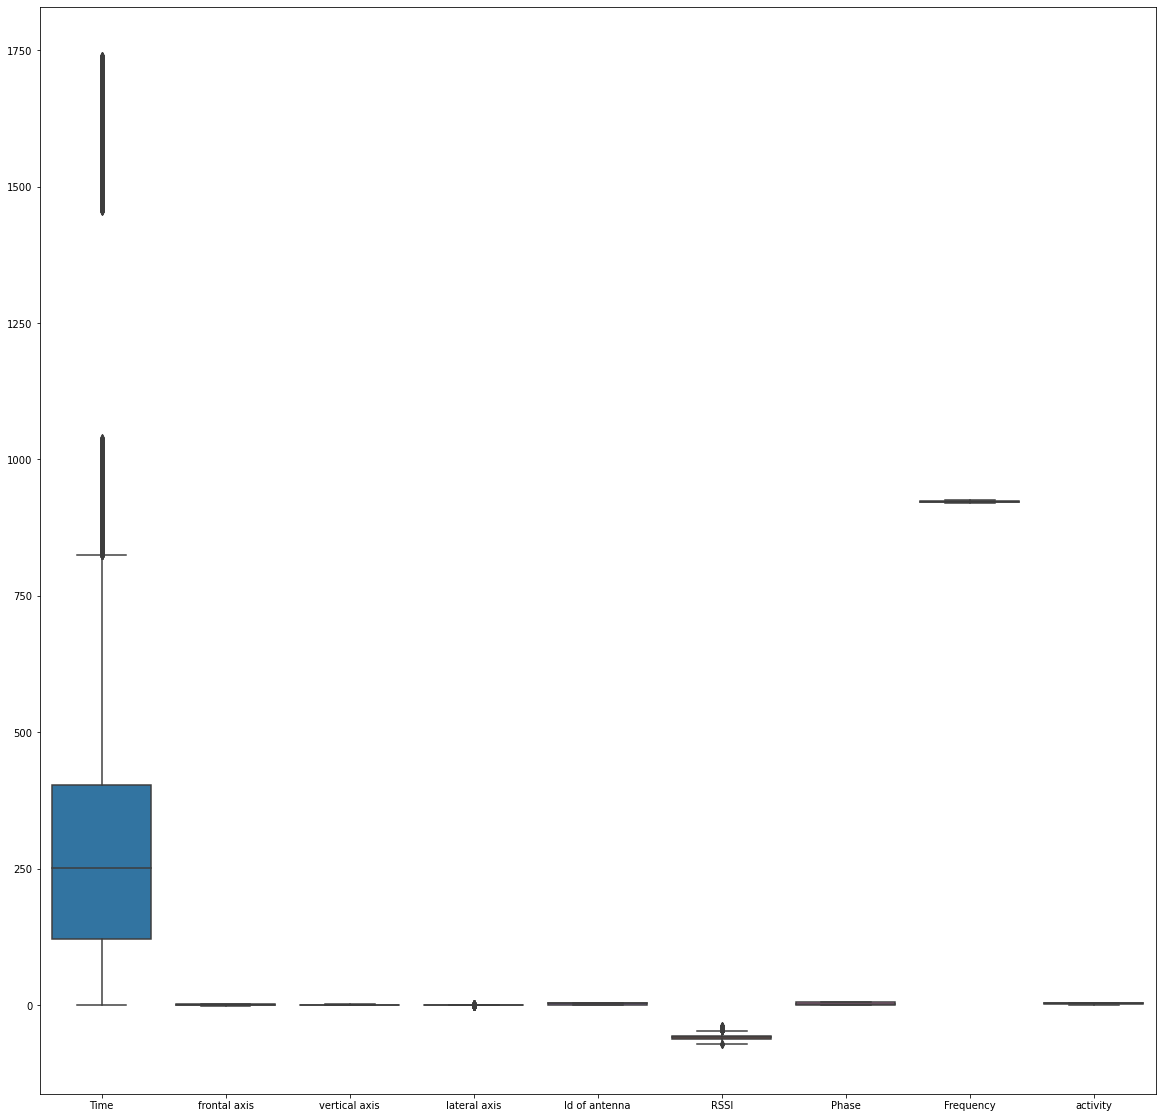

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data=df, ax=ax)

In [9]:
# loosing 30% of dataset 
q = df['Time'].quantile(.70)
df_new = df[df['Time'] < q]

In [10]:
q = df_new['lateral axis'].quantile(.99)
df_new = df_new[df_new['lateral axis'] < q]

q = df_new['RSSI'].quantile(.98)
df_new = df_new[df_new['RSSI'] < q]

<AxesSubplot:>

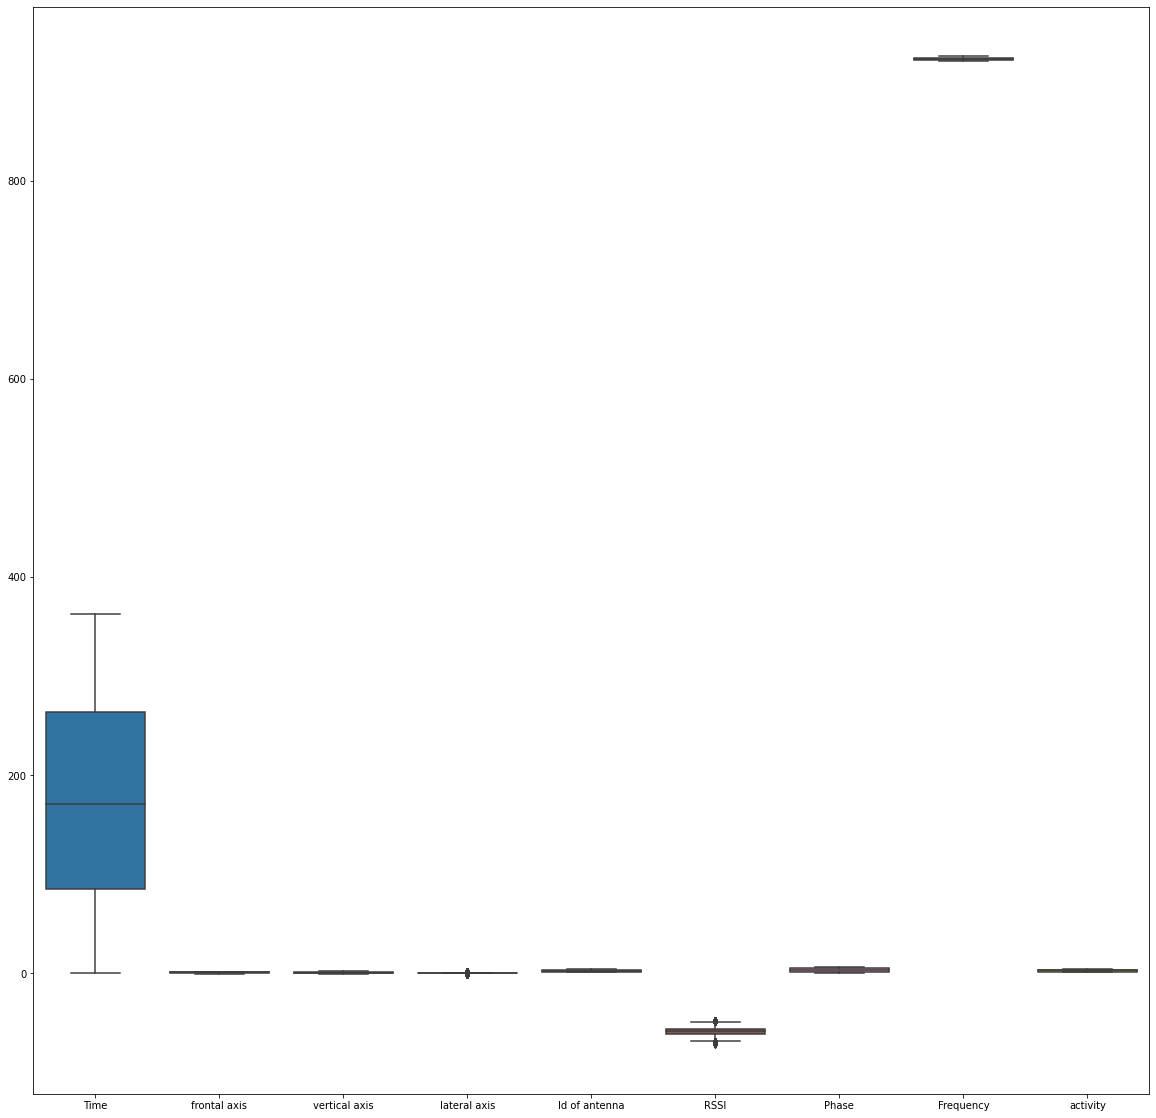

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data=df_new, ax=ax)

In [12]:
# Total reduction of dataset
print(df_new.shape)
print(df.shape)

(50933, 9)
(75128, 9)


### Split dataset in features and target variable

In [13]:
# Features
x = df_new.drop(['activity'], axis=1)   
 # Target variable
y = df_new.activity              

### For Multicolinearity 

In [14]:
def vif_score(x): 
    scaler = StandardScaler() 
    arr = scaler.fit_transform(x) 
    return pd.DataFrame([[x.columns[i], variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], columns=["FEATURE", "VIF_SCORE"]) 

In [15]:
vif_score(x)

,FEATURE,VIF_SCORE
0,Time,1.083010
1,frontal axis,6.118446
2,vertical axis,5.820114
3,lateral axis,2.050264
4,Id of antenna,1.075533
5,RSSI,1.054382
6,Phase,1.004239
7,Frequency,1.022806


### Summarize the class distribution

In [16]:
print(x.shape, y.shape)

print(Counter(y))

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(50933, 8) (50933,)
Counter({3: 30543, 1: 14568, 2: 4406, 4: 1416})
Class=3, Count=30543, Percentage=59.967%
Class=4, Count=1416, Percentage=2.780%
Class=2, Count=4406, Percentage=8.651%
Class=1, Count=14568, Percentage=28.602%


In [17]:
### Split x and y into training and testing sets

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x ,y, test_size=0.2, random_state=0)

In [63]:
x_train.shape, y_train.shape

((40746, 8), (40746,))

### Logistic Regression model

In [20]:
logistic = LogisticRegression(solver='saga')
logistic.fit(x_train, y_train)

LogisticRegression(solver='saga')

In [21]:
logistic.score(x_test, y_test)

0.8336114655934034

In [22]:
y_pred = logistic.predict(x_test)
y_pred

array([3, 1, 3, ..., 3, 3, 3])

In [23]:
pred_results = pd.DataFrame({'y_test': y_test,
                             'y_pred': y_pred})

pred_results.sample(20)

,y_test,y_pred
3433,1,1
62132,3,3
44422,1,1
17600,3,3
51124,2,1
9421,3,3
47489,3,3
16969,1,1
66883,3,3
41157,3,3


### Using Cross validation

In [26]:
# parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
#              'C': [0.1, 0.4, 0.8, 1, 2, 5],
#              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# grid_search = GridSearchCV(LogisticRegression(), parameters, cv=3, return_train_score=True)

# grid_search.fit(x_train, y_train)

# grid_search.best_params_

In [27]:
logistic_model = LogisticRegression(C =5, penalty='l2', solver='newton-cg')
logistic_model.fit(x_train, y_train)

LogisticRegression(C=5, solver='newton-cg')

In [28]:
logistic_model.score(x_test, y_test)

0.8983017571414548

In [29]:
y_pred = logistic_model.predict(x_test)

In [30]:
pred_results = pd.DataFrame({'y_test': y_test,
                             'y_pred': y_pred})

pred_results.sample(20)

,y_test,y_pred
29117,1,1
36528,1,3
13873,2,1
20999,3,3
24410,4,1
75003,1,1
1331,1,1
49451,3,3
33777,3,3
63257,3,3


In [36]:
def summarize_classification(y_test, 
                             y_pred, 
                             avg_method='weighted'):
    
    acc = accuracy_score(y_test, y_pred,normalize=True)
    num_acc = accuracy_score(y_test, y_pred,normalize=False)

    prec = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print("Test data count: ",len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

In [37]:
summarize_classification(y_test, y_pred)

Test data count:  10187
accuracy_count :  9151
accuracy_score :  0.8983017571414548
precision_score :  0.8916624179437335
recall_score :  0.8983017571414548


In [38]:
from sklearn.metrics import classification_report

target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.76      0.95      0.84      2900
     class 2       0.69      0.31      0.43       868
     class 3       0.99      1.00      1.00      6116
     class 4       0.67      0.03      0.05       303

    accuracy                           0.90     10187
   macro avg       0.78      0.57      0.58     10187
weighted avg       0.89      0.90      0.88     10187



### Area under the curve

In [39]:
auc = roc_auc_score(y_test, logistic_model.predict_proba(x_test), multi_class='ovr')
auc

0.941740066887255

### ROC
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

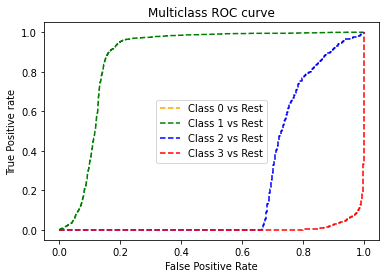

In [40]:
# fit model
clf = OneVsRestClassifier(logistic_model)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

### KNN model

In [41]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [42]:
y_pred = knn.predict(x_test)

In [43]:
knn.score(x_train,y_train)

0.9243852157266971

In [44]:
knn.score(x_test, y_test)

0.8957494846372828

In [45]:
print("The accuracy score is : ", accuracy_score(y_test,y_pred))

The accuracy score is :  0.8957494846372828


In [46]:
# param_grid = { 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
#                'leaf_size' : [18,20,25,27,30,32,34],
#                'n_neighbors' : [3,5,7,9,10,11,12,13]
#               }
# gridsearch = GridSearchCV(knn, param_grid,verbose=3)
# gridsearch.fit(x_train,y_train)

In [47]:
# gridsearch.best_params_

In [48]:
knn = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =18, n_neighbors =3)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=3)

In [49]:
knn.score(x_train,y_train)

0.9491238403769695

In [50]:
knn.score(x_test,y_test)

0.9099833120643958

### k-fold cross validation on KNN 

In [51]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(x)

In [52]:
kfold = KFold(n_splits=12)
kfold.get_n_splits(X_scaled)

12

In [53]:
from statistics import mean
knn = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =18, n_neighbors =3)
cnt =0
count=[]
train_score =[]
test_score = []

for train_index,test_index in kfold.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index] # our scaled data is an array so it can work on x[value]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
    knn.fit(X_train,y_train)
    train_score_ = knn.score(X_train,y_train)
    test_score_ =  knn.score(X_test,y_test)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    test_score.append(test_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and test score is :  ", test_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average test score is :  ", mean(test_score))

for k =  1
train_score is :   0.9895690541466758 and test score is :   0.9276796230859835
for k =  2
train_score is :   0.9889050719671008 and test score is :   0.9613663133097762
for k =  3
train_score is :   0.9882410897875257 and test score is :   0.9684334511189635
for k =  4
train_score is :   0.9887979780671693 and test score is :   0.9550058892815076
for k =  5
train_score is :   0.9878341329677861 and test score is :   0.9780918727915194
for k =  6
train_score is :   0.9883698515710339 and test score is :   0.9333176248821866
for k =  7
train_score is :   0.9884769431771938 and test score is :   0.9432139491046183
for k =  8
train_score is :   0.9887767996744415 and test score is :   0.9787935909519322
for k =  9
train_score is :   0.9885411981408897 and test score is :   0.956880301602262
for k =  10
train_score is :   0.9896763691661847 and test score is :   0.9469839773798303
for k =  11
train_score is :   0.9903617554456082 and test score is :   0.9413289349670122
for k =  

### Decision Tree model

In [65]:
dtc = DecisionTreeClassifier(random_state=42)

In [66]:
dtc.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

In [67]:
dtc.score(x_train, y_train)

1.0

In [68]:
dtc.score(x_test,y_test)

0.9833120643957985

In [69]:
y_pred = dtc.predict(x_test)

In [70]:

# grid_param = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth' : range(2,32,1),
#     'min_samples_leaf' : range(1,10,1),
#     'min_samples_split': range(2,10,1),
#     'splitter' : ['best', 'random']
    
# }

In [71]:
# grid_search = GridSearchCV(estimator=dtc,
#                      param_grid=grid_param,
#                      cv=5,
#                     n_jobs =-1)

In [72]:
# grid_search.fit(x_train,y_train)

In [73]:
# best_parameters = grid_search.best_params_
# best_parameters

In [74]:
dtc_model = DecisionTreeClassifier(criterion = 'entropy', max_depth =17, min_samples_leaf= 1, min_samples_split= 3, splitter ='best')
dtc_model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_split=3)

In [75]:
dtc_model.score(x_test,y_test)

0.9852753509374693

In [80]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test, dtc.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.98      0.98      0.98      2900
     class 2       0.96      0.96      0.96       868
     class 3       1.00      1.00      1.00      6116
     class 4       0.80      0.80      0.80       303

    accuracy                           0.98     10187
   macro avg       0.93      0.93      0.93     10187
weighted avg       0.98      0.98      0.98     10187



In [79]:
roc_auc_score(y_test, dtc_model.predict_proba(x_test), multi_class='ovr')

0.969983771229194

### Random forest model

In [81]:
rand_clf = RandomForestClassifier(random_state=6)
rand_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=6)

In [82]:
rand_clf.score(x_train, y_train)

0.9999754577136406

In [83]:
rand_clf.score(x_test, y_test)

0.9912633748895652

In [84]:
# grid_param = {
#     "n_estimators" : [90,100,115,130],
#     'criterion': ['gini', 'entropy'],
#     'max_depth' : range(2,20,1),
#     'min_samples_leaf' : range(1,10,1),
#     'min_samples_split': range(2,10,1),
#     'max_features' : ['auto','log2']
# }
# grid_search = GridSearchCV(estimator=rand_clf,param_grid=grid_param,cv=5,n_jobs =-1,verbose = 3)
# grid_search.fit(x_train,y_train)

In [86]:
roc_auc_score(y_test, rand_clf.predict_proba(x_test), multi_class='ovr')

0.9986966213469451

In [87]:
from sklearn.metrics import classification_report

target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.98      0.98      0.98      2900
     class 2       0.96      0.96      0.96       868
     class 3       1.00      1.00      1.00      6116
     class 4       0.80      0.80      0.80       303

    accuracy                           0.98     10187
   macro avg       0.93      0.93      0.93     10187
weighted avg       0.98      0.98      0.98     10187



### SVC model

In [101]:
svc = SVC(probability=True)
svc.fit(x_train,y_train)

SVC(probability=True)

In [102]:
svc.score(x_test, y_test)

0.6003730244429174

In [103]:
y_pred = svc.predict(x_test)

In [104]:
roc_auc_score(y_test, svc.predict_proba(x_test), multi_class='ovr')

0.9074842173997746

In [92]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.98      0.98      0.98      2900
     class 2       0.96      0.96      0.96       868
     class 3       1.00      1.00      1.00      6116
     class 4       0.80      0.80      0.80       303

    accuracy                           0.98     10187
   macro avg       0.93      0.93      0.93     10187
weighted avg       0.98      0.98      0.98     10187



### Compare models:

In [94]:
def compare_model():
    print("Logistic Regression", logistic_model.score(x_test, y_test))
    print("KNN Classifier", knn.score(x_test, y_test))
    print("Decision Tree", dtc.score(x_test,y_test))
    print("Random Forest Classifier", rand_clf.score(x_test, y_test))
    print("Support Vector Classifier", svc.score(x_test, y_test))
    
    
compare_model()    

Logistic Regression 0.8983017571414548
KNN Classifier 0.6003730244429174
Decision Tree 0.9833120643957985
Random Forest Classifier 0.9912633748895652
Support Vector Classifier 0.6003730244429174


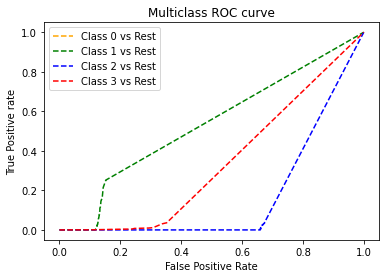

In [95]:
# fit model
clf = OneVsRestClassifier(rand_clf)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [99]:
import pickle
with open('RandomForestClassifier.sav', 'wb') as f:
    pickle.dump(rand_clf,f)